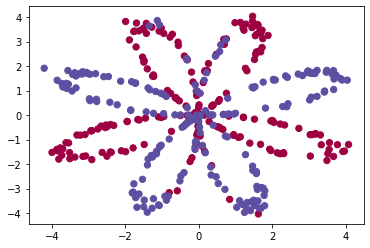

In [127]:
import matplotlib.pyplot as plt
import numpy as np

def get_dataset():
  np.random.seed(1)
  m = 400
  N = int(m / 2) # number of points per class
  
  dimension = 2
  X = np.zeros((m, dimension)) # data matrix where each row is a single example
  Y = np.zeros((m, 1), dtype='uint8') # labels vector (0 for red, 1 for blue)
  flower_ray = 4

  for j in range(2):
      indexs = range(N*j, N*(j+1))
      t = np.linspace(j*3.12, (j+1)*3.12, N) + np.random.randn(N)*0.2
      r = flower_ray * np.sin(4*t) + np.random.randn(N) * 0.2
      X[indexs] = np.c_[r*np.sin(t), r*np.cos(t)]
      Y[indexs] = j
      
  X = X.T
  Y = Y.T
  return X, Y

if __name__ == "__main__":
  X, Y = get_dataset()
  plt.scatter(X[0, :], X[1, :], c=Y[0], s=40, cmap=plt.cm.Spectral);

In [128]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

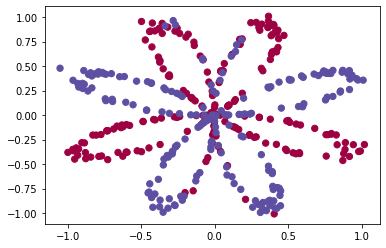

In [129]:
points, labels = get_dataset()
points = points / 4
plt.scatter(points[0, :], points[1, :], c=labels[0], s=40, cmap=plt.cm.Spectral);

In [130]:
X_train, X_test, Y_train, Y_test = train_test_split(list(zip(points[0, :], points[1, :])), labels[0], test_size=0.2)

In [131]:
Y_train, Y_test = list(Y_train), list(Y_test)

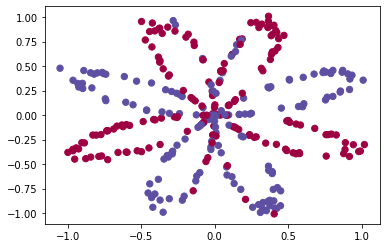

In [132]:
plt.scatter([x[0] for x in X_train], [y[1] for y in X_train], c=Y_train, s=40, cmap=plt.cm.Spectral)

In [133]:
class NeuralNetwork:
    def __init__(self, neuron_nums=(2, 1)):
        self.layers = []
        for i, neurons_num in enumerate(neuron_nums):
            self.layers.append(Layer(neurons_num, layer=i, previous_neurons=neuron_nums[i-1]))
    
    def activation_function(self, func):
        self.activation = func
    
    def layer_activation_func(self, func):
        self.layer_activation = func
        
    def loss_func(self, func):
        self.loss = func
        self.history = []
    
    def train_step(self, input_, output):
        for i, layer in enumerate(self.layers):
            if i == 0:
                data = input_
                layer.get_data(data)
                layer.split_data()
            layer.send_data(self.layers[i+1], activation_func=self.layer_activation)
            if i == len(self.layers)-2:
                break
        nn_output = self.activation(self.layers[-1].get_result()[0])
        nn_output = round(nn_output)
        loss = self.loss(nn_output, output)
        for layer in self.layers:
            layer.change_weights(loss)
            
    def predict(self, input_):
        for i, layer in enumerate(self.layers):
            if i == 0:
                data = input_
                layer.get_data(data)
                layer.split_data()
            layer.send_data(self.layers[i+1], activation_func=self.layer_activation)
            if i == len(self.layers)-2:
                break
        nn_output = self.activation(self.layers[-1].get_result()[0])
        nn_output = round(nn_output)
        return nn_output

In [150]:
class Layer:
    def __init__(self, neurons_num, layer=0, previous_neurons=0):
        self.layer = layer
        if layer == 0:
            self.neurons = [Neuron(1) for _ in range(neurons_num)]
        else:
            self.neurons = [Neuron(previous_neurons) for _ in range(neurons_num)]
    
    def get_data(self, data):
        self.data = data
    
    def split_data(self):
        if self.layer==0:
            for data, neuron in zip(self.data, self.neurons):
                neuron.get_data(data)
        else:
            for neuron in self.neurons:
                neuron.get_data(self.data)
    
    def send_data(self, layer, activation_func):
        layer.get_data([activation_func(neuron.sum_()) for neuron in self.neurons])
        layer.split_data()
    
    def get_result(self):
        return [neuron.sum_() for neuron in self.neurons]
    
    def change_weights(self, loss):
        for neuron in self.neurons:
            neuron.change_weights(loss)

In [151]:
from random import random
from math import exp

In [169]:
class Neuron:
    def __init__(self, input_size):
        self.weights = [random()*2-1 for _ in range(input_size)]
    
    def get_data(self, data):
        self.data = data if isinstance(data, list) else [data]
        return self
    
    def sum_(self):
        res = 0
        for weight, data in zip(self.weights, self.data):
            res += weight*data
        return res
    
    def change_weights(self, loss):
        for i, data in enumerate(self.data):
            self.weights[i] -= loss * data * 0.00001

In [170]:
def sigmoid(x):
    return 1/(1+exp(-x))

In [171]:
def tanh(x):
    return (exp(x) - exp(-x)) / (exp(x) + exp(-x))

In [172]:
def loss(y_pred, y_true):
    res = y_true - y_pred
    return res

In [173]:
nn = NeuralNetwork(neuron_nums=(2,3, 1))
nn.activation_function(sigmoid)
nn.layer_activation_func(tanh)
nn.loss_func(loss)

In [174]:
for x, y in zip(X_train + X_test, Y_train + Y_test):
    nn.train_step(x, y)

In [175]:
nn.layers[2].neurons[0].weights

[-0.0021044092585662797, 0.08456685282636722, 0.2526307029397224]

In [176]:
t, f = 0, 0
for x, y in zip(X_test+X_train, Y_test+Y_train):
    if y != nn.predict(x):
        f += 1
    else:
        t += 1
print(t, f)

199 201


In [168]:
predictions = []
for x in (X_test + X_train):
    predictions.append(nn.predict(x))

In [145]:
def plot_decision_boundary(pred_func):# Set min and max values and give it some padding
    x_min, x_max = points[0, :].min() - .5, points[0, :].max() + .5
    y_min, y_max = points[1, :].min() - .5, points[1, :].max() + .5
    h = 0.1
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    z = []
    for x, y in zip(xx, yy):
        for x, y in zip(x, y):
            z.append(pred_func((x, y)))
    z = np.array(z)
    z = z.reshape(xx.shape)
    plt.contourf(xx, yy, z, cmap=plt.cm.Spectral)
    plt.scatter(points[0, :], points[1, :], c=labels[0], cmap=plt.cm.Spectral)

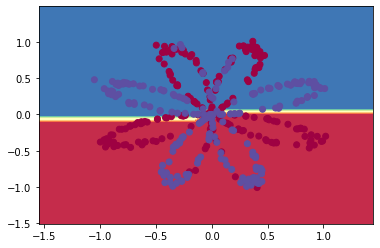

In [146]:
plot_decision_boundary(nn.predict)

In [106]:
print(nn.predict((-0.255, 0.88)))
print(X_test[10], Y_test[10]) 

1
(-0.25562124167359584, 0.8879788894864712) 0


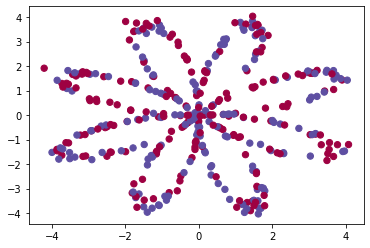

In [114]:
plt.scatter(X[0, :], X[1, :], c=predictions, s=40, cmap=plt.cm.Spectral)